## K-means clustering
#### This notebook presents the machine learning analysis of the gapminder dataset accessible from http://www.gapminder.org/data/ 

In [1]:
%matplotlib inline
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from pandas import Series, DataFrame
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
sns.set_style('whitegrid')
sns.set_context('talk')
# Eliminate false positive SettingWithCopyWarning
pd.options.mode.chained_assignment = None

### Data Management

In [2]:
# Make results reproducible
np.random.seed(12345)
# Load the dataset
df = pd.read_csv('gapminder.csv')
variables = ['incomeperperson', 'alcconsumption', 'co2emissions', 'femaleemployrate', 
                'internetuserate', 'lifeexpectancy','employrate','urbanrate','breastcancerper100th'] 
# convert to numeric format
for variable in variables:
    df[variable] = pd.to_numeric(df[variable], errors='coerce')

# listwise deletion of missing values
subset = df[variables].dropna()

# Print the rows and columns of the data frame
print('Size of study data')
print(subset.shape)

Size of study data
(157, 9)


In [3]:
n_estimators=25

subset['cancerbins'] = pd.cut(subset['breastcancerper100th'], 5, labels=['0-20','21-40','41-60','61-80','81-110'])
subset['cancerbins'] = subset['cancerbins'].astype('category')

variables.pop(8)

predictors = subset[variables]
target = subset['cancerbins']

# Split into training and testing sets+
training_data, test_data, training_target, test_target  = train_test_split(predictors, target, test_size=.25)

# Get size of training set
print('Size of training data')
print(training_data.shape)

Size of training data
(117, 8)


In [4]:
# Fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(training_data,training_target)

# Display the relative importance of each attribute
feature_name = list(predictors.columns.values)
feature_importance = list(model.feature_importances_)
features = pd.DataFrame({'name':feature_name, 'importance':feature_importance}).sort_values(by='importance', ascending=False)
print(features.head(len(feature_name)))

   importance              name
0    0.155067   incomeperperson
5    0.145578    lifeexpectancy
1    0.139306    alcconsumption
3    0.130949  femaleemployrate
4    0.124402   internetuserate
7    0.123715         urbanrate
6    0.107893        employrate
2    0.073090      co2emissions


In [5]:
variables = ['alcconsumption','internetuserate', 'urbanrate', 'incomeperperson', 'lifeexpectancy'] 
# convert to numeric format
for variable in variables:
    df[variable] = pd.to_numeric(df[variable], errors='coerce')

# Center and scale data
for variable in variables:
    subset[variable]=preprocessing.scale(subset[variable].astype('float64'))
    
features = subset[variables]
target = subset[['breastcancerper100th']]

### Split Data into Training and Test Sets

In [6]:
training_data, test_data, training_target, test_target  = train_test_split(features, target, test_size=.3)
print('Size of training data')
print(training_data.shape)

Size of training data
(109, 5)


### Determine the Number of Clusters

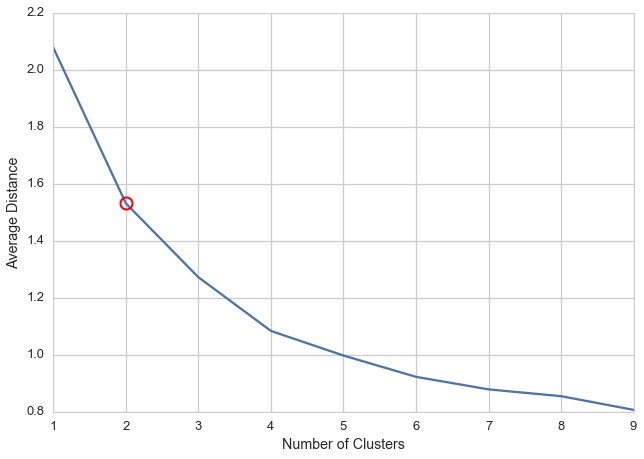

In [7]:
# Identify number of clusters using the elbow method
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(training_data)
    clusassign=model.predict(training_data)
    dist = sum(np.min(cdist(training_data, model.cluster_centers_, 'euclidean'), axis=1))
    meandist.append(dist / training_data.shape[0])

# Visualize the elbow
k = 2

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(clusters, meandist)
ax.plot(clusters[(k-1)], meandist[(k-1)], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.show()

### Visualize Clustered Data

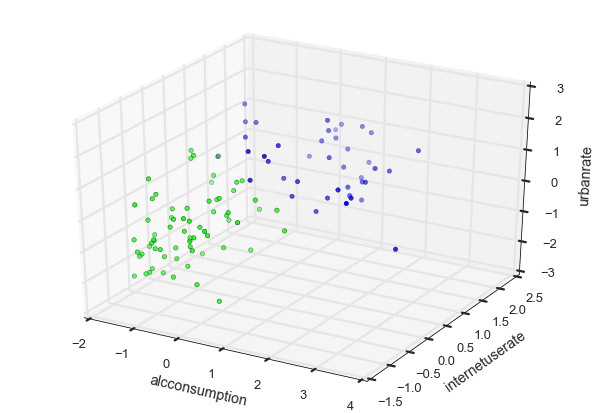

In [8]:
model=KMeans(n_clusters=k)
model.fit(training_data)
training_data['cluster'] = model.labels_
# Change Colors
my_cmap = plt.cm.get_cmap('brg')
my_cmap.set_under('w')

x = training_data.iloc[:,0]
y = training_data.iloc[:,1]
z = training_data.iloc[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=training_data['cluster'], cmap=my_cmap)
ax.set_xlabel(training_data.columns.values[0], labelpad=15)
ax.set_ylabel(training_data.columns.values[1], labelpad=15)
ax.set_zlabel(training_data.columns.values[2], labelpad=15)
plt.show()

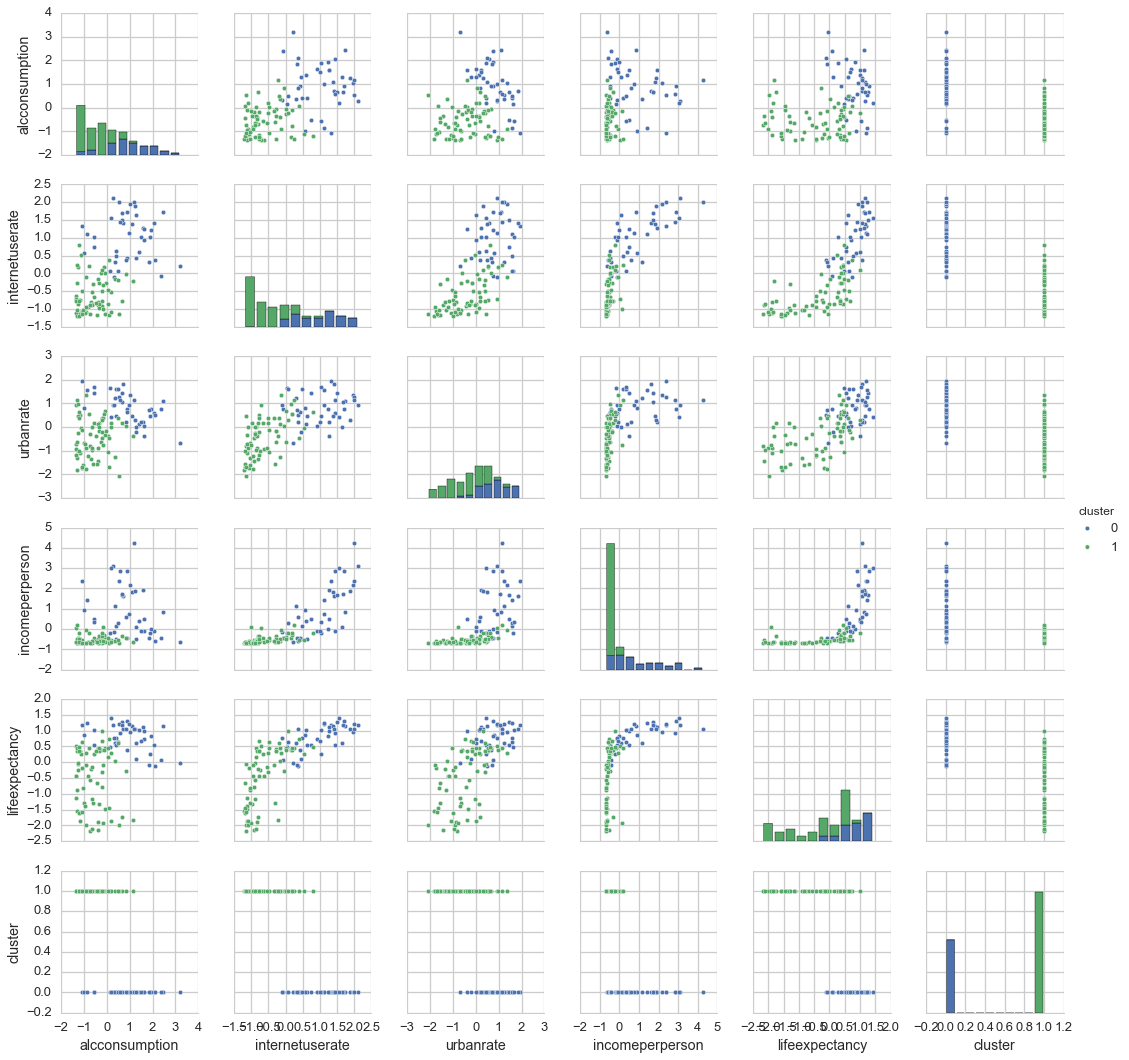

In [9]:
sns.pairplot(training_data, hue ='cluster')

### Examine Differences Between Clusters

In [10]:
# Add Cluster label to training targets
training_target['cluster'] = model.labels_
# OLS regression
income_model = smf.ols(formula='breastcancerper100th ~ C(cluster)', data=training_target).fit()
print (income_model.summary())

                             OLS Regression Results                             
Dep. Variable:     breastcancerper100th   R-squared:                       0.505
Model:                              OLS   Adj. R-squared:                  0.501
Method:                   Least Squares   F-statistic:                     109.3
Date:                  Fri, 22 Apr 2016   Prob (F-statistic):           4.76e-18
Time:                          16:53:13   Log-Likelihood:                -456.04
No. Observations:                   109   AIC:                             916.1
Df Residuals:                       107   BIC:                             921.5
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          59.

In [11]:
print ('means for features by cluster')
m1= training_target.groupby('cluster').mean()
print (m1)

means for features by cluster
         breastcancerper100th
cluster                      
0                   59.117073
1                   25.991176


In [12]:
print ('standard deviations for features by cluster')
m2= training_target.groupby('cluster').std()
print (m2)

standard deviations for features by cluster
         breastcancerper100th
cluster                      
0                   21.978511
1                   11.033243


In [13]:
mc1 = multi.MultiComparison(training_target['breastcancerper100th'], training_target['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
  0      1    -33.1259 -39.4073 -26.8445  True 
-----------------------------------------------


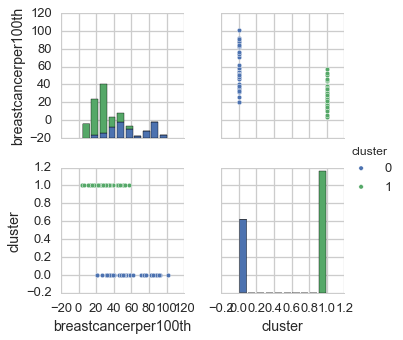

In [14]:
sns.pairplot(training_target, hue ='cluster')